In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.models import load_model
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os
from keras.src.utils.np_utils import to_categorical
import seaborn as sns

In [2]:
int2emotions = {0:'angry',1:'fear',2:'happy',3:'neutral',4:'sad',5:'surprise'}
emotions2int = {'angry':0,'fear':1,'happy':2,'neutral':3,'sad':4,'surprise':5}

dic = {'images':[], 'labels':[], 'purpose':[]}
    
for d in os.listdir('Data/'):
    print(d)
    if(d!='.DS_Store'):
        for emotion in os.listdir(f'Data/{d}'):
            print(emotion)
            if(emotion!='.DS_Store'):
                for i in os.listdir(f'Data/{d}/{emotion}'):
                    img = cv2.imread(f'Data/{d}/{emotion}/{i}',0)
                    img = img.reshape(48,48,1)
            
                    dic['images'].append(img)
                    dic['labels'].append(emotion)
            
                    if d=='train':
                        dic['purpose'].append('T')
                    else:
                        dic['purpose'].append('V')

.DS_Store
test
happy
.DS_Store
sad
fear
surprise
neutral
angry
train
happy
.DS_Store
sad
fear
surprise
neutral
angry


In [3]:
df = pd.DataFrame(dic)
df.head()

,images,labels,purpose
0,"[[[5], [4], [5], [9], [10], [9], [10], [12], [...",happy,V
1,"[[[19], [21], [22], [18], [20], [21], [16], [1...",happy,V
2,"[[[228], [229], [230], [229], [228], [227], [2...",happy,V
3,"[[[25], [33], [43], [30], [46], [84], [105], [...",happy,V
4,"[[[33], [29], [15], [15], [20], [36], [40], [5...",happy,V


In [4]:
train_data = df[df['purpose']=='T']
val_data = df[df['purpose']=='V']

In [5]:
train_data.head()

,images,labels,purpose
7067,"[[[108], [83], [63], [65], [89], [111], [121],...",happy,T
7068,"[[[137], [142], [159], [162], [158], [134], [1...",happy,T
7069,"[[[111], [148], [155], [167], [181], [191], [1...",happy,T
7070,"[[[151], [156], [121], [100], [80], [116], [15...",happy,T
7071,"[[[248], [187], [149], [130], [97], [140], [13...",happy,T


In [6]:
val_data.head()

,images,labels,purpose
0,"[[[5], [4], [5], [9], [10], [9], [10], [12], [...",happy,V
1,"[[[19], [21], [22], [18], [20], [21], [16], [1...",happy,V
2,"[[[228], [229], [230], [229], [228], [227], [2...",happy,V
3,"[[[25], [33], [43], [30], [46], [84], [105], [...",happy,V
4,"[[[33], [29], [15], [15], [20], [36], [40], [5...",happy,V


In [7]:
train_data['labels'].value_counts()

labels
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
Name: count, dtype: int64

In [8]:
val_data['labels'].value_counts()

labels
happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
Name: count, dtype: int64

In [9]:
happy_df = train_data[train_data['labels']=='happy'].sample(n=3171)
neutral_df = train_data[train_data['labels']=='neutral'].sample(n=3171)
sad_df = train_data[train_data['labels']=='sad'].sample(n=3171)
fear_df = train_data[train_data['labels']=='fear'].sample(n=3171)
angry_df = train_data[train_data['labels']=='angry'].sample(n=3171)
surprise_df = train_data[train_data['labels']=='surprise'].sample(n=3171)

train_data = pd.concat([happy_df,neutral_df,sad_df,fear_df,angry_df,surprise_df])

train_data = train_data.sample(frac=1)
train_data.reset_index(inplace=True)
train_data.drop('index',inplace=True,axis=1)

train_data.head()

,images,labels,purpose
0,"[[[83], [71], [64], [67], [74], [83], [85], [9...",sad,T
1,"[[[58], [60], [57], [59], [19], [1], [8], [2],...",surprise,T
2,"[[[255], [255], [255], [255], [255], [255], [2...",surprise,T
3,"[[[255], [255], [255], [255], [255], [255], [2...",neutral,T
4,"[[[193], [196], [191], [190], [193], [191], [1...",angry,T


In [10]:
train_data['labels'].value_counts()

labels
sad         3171
surprise    3171
neutral     3171
angry       3171
happy       3171
fear        3171
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

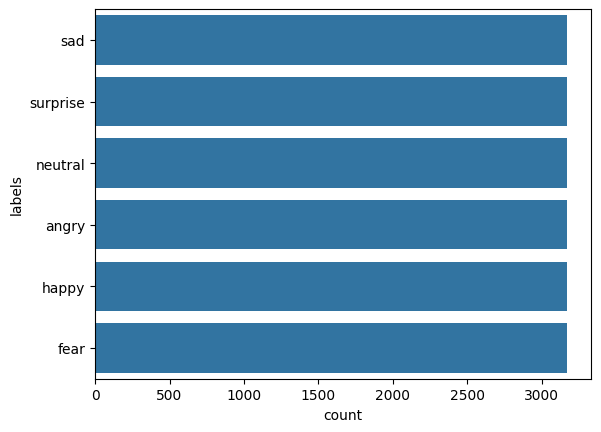

In [11]:
sns.countplot(train_data['labels'])

In [12]:
batch_size= 32
classes = 6
rows,columns=48,48

In [13]:
train_labels = list(train_data['labels'].replace(emotions2int))
train_labels = to_categorical(train_labels)

val_labels = list(val_data['labels'].replace(emotions2int))
val_labels = to_categorical(val_labels)

In [14]:
train_data = list(train_data['images'])
train_data = np.array(train_data)

val_data = list(val_data['images'])
val_data = np.array(val_data)

In [15]:
train_data.shape

(19026, 48, 48, 1)

In [16]:
val_data.shape

(7067, 48, 48, 1)

## Creating Our Model

In [18]:
model = Sequential()

# First Block
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Second Block
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Third Block
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fourth Block
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fifth Block
model.add(Flatten())
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Sixth Block
model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Seventh Block
model.add(Dense(64,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Eighth Block
model.add(Dense(classes,activation='softmax',kernel_initializer='he_normal'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                        

In [19]:
checkpoint = ModelCheckpoint('/Users/ashishchauhan/Desktop/Emotion_detection_project/model/class_emotion_detector_V2.h5',
                             save_best_only=True,
                             mode='min',
                             monitor='loss',
                             verbose=1)

earlystopping = EarlyStopping(patience=10,
                             verbose=1,
                             min_delta=0,
                             monitor='accuracy',
                             restore_best_weights=True)


callbacks = [checkpoint, earlystopping]

model.compile(metrics=['accuracy'],
             optimizer='rmsprop',
             loss='categorical_crossentropy')

train_samples = 19026
validation_samples = 7067
batch_size = 64
epochs=25

# Training Our Model

In [20]:
history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=(val_data,val_labels),
                    validation_steps=validation_samples//batch_size,
                    callbacks=callbacks)

Epoch 1/25
297/297 [==============================] - ETA: 0s - loss: 2.2608 - accuracy: 0.2042WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 110 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: loss improved from inf to 2.26075, saving model to /Users/ashishchauhan/Desktop/Emotion_detection_project/model/class_emotion_detector_V2.h5
297/297 [==============================] - 324s 1s/step - loss: 2.2608 - accuracy: 0.2042 - val_loss: 3.5910 - val_accuracy: 0.1486
Epoch 2/25


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


297/297 [==============================] - ETA: 0s - loss: 1.6420 - accuracy: 0.3302
Epoch 2: loss improved from 2.26075 to 1.64195, saving model to /Users/ashishchauhan/Desktop/Emotion_detection_project/model/class_emotion_detector_V2.h5
297/297 [==============================] - 315s 1s/step - loss: 1.6420 - accuracy: 0.3302
Epoch 3/25
297/297 [==============================] - ETA: 0s - loss: 1.3922 - accuracy: 0.4451
Epoch 3: loss improved from 1.64195 to 1.39221, saving model to /Users/ashishchauhan/Desktop/Emotion_detection_project/model/class_emotion_detector_V2.h5
297/297 [==============================] - 339s 1s/step - loss: 1.3922 - accuracy: 0.4451
Epoch 4/25
297/297 [==============================] - ETA: 0s - loss: 1.2777 - accuracy: 0.5043
Epoch 4: loss improved from 1.39221 to 1.27766, saving model to /Users/ashishchauhan/Desktop/Emotion_detection_project/model/class_emotion_detector_V2.h5
297/297 [==============================] - 327s 1s/step - loss: 1.2777 - accuracy

# Live Predictor

In [3]:
model = load_model('/Users/ashishchauhan/Desktop/Emotion_detection_project/model/class_emotion_detector_V2.h5')
cv2.startWindowThread()
cap = cv2.VideoCapture(0)

classifier = cv2.CascadeClassifier('/Users/ashishchauhan/Desktop/Emotion_detection_project/live/haarcascade_frontalface_default.xml')

def detect_face(frame):
    faces=classifier.detectMultiScale(frame,1.3,4)
    if faces==():
        return frame
    for x,y,w,h in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(172,42,251),2)
        face = frame[y:y+h,x:x+w]
        face = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face,(48,48))
        face = face.reshape(1,48,48,1)
        cv2.putText(frame,text=int2emotions[np.argmax(model.predict(face))],
                    org=(x,y-15),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(106,40,243),thickness=2)
    return frame

while 1:
    ret,frame= cap.read()
    if ret==True:
        cv2.imshow('emotion_detector',detect_face(frame))
        if cv2.waitKey(1)==27:
            break
cap.release()
cv2.destroyAllWindows()

/var/folders/sy/lscctv1141q8y4mwbvmwrpt80000gn/T/ipykernel_6121/2875727576.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces==():


1/1 [==============================] - 0s 20ms/step
